# Vehicle dynamics

The position of vehicle $i$ is $x_i(t)$ The distance to the vehicle or object
in front of vehicle $i$ is $q_i(t)$.

The vehicle speed $v_i(t) = \dot{x}_i(t)$. 

The control input to the vehicle is the acceleration $u_i$.

The desired distance to the obstacle in front $\hat{q}_i$ is calculated by scaling
with the current vehicle speed:

$$ \hat{q}_i(t) = k_q v_i(t) $$

Define a PD controller as:

$$ r_i(t) = q_i(t) - \hat{q}_i(t) $$
$$ u_i = k_p r_i(t) + k_d \frac{r_i(t) - r_i(t-\Delta t)}{\Delta t} $$


## Single vehicle approaching fixed obstacle

Let there be a vehicle starting at $x=0$ with an obstacle at $200$ so $q=200-x$.

In [1]:
%matplotlib notebook
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.transforms import Affine2D


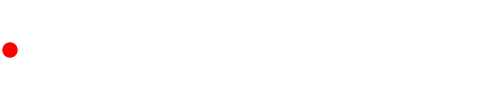

In [3]:
# Dynamic variables
x = 0
v = 0

# Runway
q0 = 200

# Desired distance
kq = 5.0

# Max/min speeds
v_max = 10.0
v_min = 0.0

# Timestep
dt = 0.05

# r() at previous timestep
r_old = 0

# Control params
k_d = 0.05
k_p = 0.5

def q():
    global q0, x
    return q0 - x

def qhat() -> float:
    global kq,v
    return np.max([5.0, kq*v])

def r():
    return q() - qhat()

def r_diff():
    global r_old, dt
    return (r() - r_old) / dt

def u():
    global k_p, k_d
    return k_p * r() + k_d * r_diff()

def step():
    global x,v
    u_calc = u()
    v_calc = v + dt * u_calc
    v_calc = np.min([v_max, np.max([v_min, v_calc])])
    x_calc = x + dt * v_calc

    x = x_calc
    v = v_calc

    r_old = r()


def update(_f):
    step()
    step()
    step()
    tx = Affine2D.from_values(1, 0, 0, 1, 2*x+10, 50)
    circ.set_transform(tx)
    
fig = plt.figure(figsize=(5, 1))
ax = fig.add_axes([0, 0, 1, 1], frameon=False)
ax.set_xlim(-10, 210), ax.set_xticks([])
ax.set_ylim(0, 20), ax.set_yticks([])

circ = plt.Circle((0,0), radius=7, color='r')
tx = Affine2D.from_values(1, 0, 0, 1, 2*x+10, 50)
circ.set_transform(tx)
ax.add_patch(circ)

anim = FuncAnimation(fig, update, frames=1000, interval=50)

plt.show()

In [2]:
class RandomTraffic:
    def __init__(self, 
        n_vehicles: int,
        track_length: float,
        k_p: float, 
        k_d: float,
        k_q: float,
        k_qmin: float,
        v_min: float,
        v_max: float
    ) -> None:
        self.n_vehicles = n_vehicles
        self.track_length = track_length
        self.k_p = k_p
        self.k_d = k_d
        self.k_q = k_q
        self.k_qmin = k_qmin
        self.v_min = v_min
        self.v_max = v_max
        self.position = np.zeros(n_vehicles, dtype=np.float32)
        self.velocity = np.zeros(n_vehicles, dtype=np.float32)
        self.active = np.zeros(n_vehicles, dtype=np.bool8)
        self.r_old = np.zeros(n_vehicles, dtype=np.float32)
    
    def enable_vehicle(self):
        """Find the first available vehicle slot and set active to True"""
        argmin = self.active.argmin()
        
        if not self.active[argmin]:
            # If argmin is already active, there's no space to add another vehicle
            self.active[argmin] = True
            self.position[argmin] = 0.0
            self.velocity[argmin] = 0.0

    def q(self):
        output = np.zeros_like(self.position)
        diffs = np.diff(self.position[self.active][::-1])[::-1]
        output[self.active] = np.concatenate([[100], diffs])
        return output

    def qhat(self):
        return np.max([self.k_qmin * np.ones_like(self.velocity), self.k_q * self.velocity], axis=0)


    def r(self):
        return self.q() - self.qhat()

    def r_diff(self, dt):
        return (self.r() - self.r_old) / dt

    def u(self, dt):
        return self.k_p * self.r() + self.k_d * self.r_diff(dt)
        
    def step(self, dt: float):
        u_calc = self.u(dt)
        v_calc = self.velocity + dt * u_calc
        v_calc = np.clip(v_calc, self.v_min, self.v_max)
        x_calc = self.position + dt * v_calc

        self.velocity = v_calc
        self.position = x_calc

        self.r_old = self.r()
        

In [3]:
class Circles:
    def __init__(self, traffic: RandomTraffic):
        self.traffic = traffic
        self.fig = plt.figure(figsize=(5, 1))
        self.ax = self.fig.add_axes([0, 0, 1, 1], frameon=False)

        self.circles = [plt.Circle((0,0), radius=7, color='r') for i in range(traffic.n_vehicles)]
        for circ in self.circles:
            self.ax.add_patch(circ)
            circ.set_visible(False)

    def update(self):
        for circ, position, active in zip(self.circles, self.traffic.position, self.traffic.active):
            circ.set_visible(active)
            tx = Affine2D.from_values(1, 0, 0, 1, position*2 + 10, 20)
            circ.set_transform(tx)


<IPython.core.display.Javascript object>


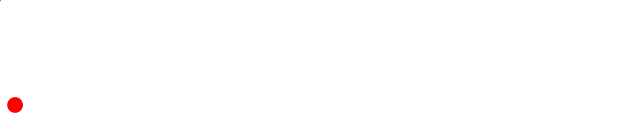

In [11]:
t = RandomTraffic(
    n_vehicles=10,
    track_length=200,
    k_p=0.5,
    k_d=0.1,
    k_q=1,
    k_qmin=1,
    v_min=0,
    v_max=40
)
t.enable_vehicle()
circles = Circles(t)

def update(frame):
    if np.random.rand() < 0.05:
        t.enable_vehicle()
    t.step(0.01)
    circles.update()

anim = FuncAnimation(circles.fig, update, 10)

In [6]:
np.array([0,1,3])[::-1]

array([3, 1, 0])